In [1]:
import os
import pickle
import copy
import logging

from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ConformationEnsemble import ConformationEnsembleLibrary

In [2]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [3]:
data_dir_path = 'data/'

In [7]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library_with_h.p'), 'rb') as f :
    general_CEL = pickle.load(f)

In [8]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_refined_conf_ensemble_library_with_h.p'), 'rb') as f :
    refined_CEL = pickle.load(f)

In [9]:
all_CEL = general_CEL
all_CEL.merge(refined_CEL)

In [6]:
def ccdc_conformers_to_rdkit_mol(ccdc_conformers, rdkit_mol) :
        
    generated_conf_ids = []

    for conformer in ccdc_conformers :
        new_rdkit_conf = copy.deepcopy(rdkit_mol).GetConformer()
        for i in range(new_rdkit_conf.GetNumAtoms()) :
            atom = conformer.molecule.atoms[i]
            point3d = Point3D(*atom.coordinates)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        new_rdkit_conf.SetProp('Generator', 'CCDC')
        conf_id = rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)
        generated_conf_ids.append(conf_id)

    return generated_conf_ids

In [7]:
initial_ccdc_mols = []
corresponding_ce_mols = []
for smiles, conf_ensemble in tqdm(all_CEL.get_unique_molecules()) :
    if conf_ensemble.mol.GetNumHeavyAtoms() < 50 :
        mol2block = Chem.MolToMolBlock(conf_ensemble.mol)
        ccdc_mol = Molecule.from_string(mol2block)
        if conf_ensemble.mol.GetNumAtoms() == len(ccdc_mol.atoms) :
            initial_ccdc_mols.append(ccdc_mol)
            corresponding_ce_mols.append(conf_ensemble.mol)

100%|███████████████████████████████████| 12348/12348 [00:04<00:00, 2503.27it/s]


In [8]:
n_conf_per_chunk = 100
chunk_idxs = [list(range(i, i + n_conf_per_chunk)) for i in range(0, len(initial_ccdc_mols), n_conf_per_chunk)]
#mol_lists = [initial_ccdc_mols[i:i + n_conf_per_chunk] for i in range(0, len(initial_ccdc_mols), n_conf_per_chunk)]

In [9]:
ccdc_conformer_generator = ConformerGenerator(nthreads=12)
ccdc_conformer_generator.settings.max_conformers = 50

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


In [10]:
generated_mols = []
for chunk_idx in tqdm(chunk_idxs) :
    
    mol_list = [mol for i, mol in enumerate(initial_ccdc_mols) if i in chunk_idx]
    ce_mols = [mol for i, mol in enumerate(corresponding_ce_mols) if i in chunk_idx]
    
    conformers = ccdc_conformer_generator.generate(mol_list)
    
    for ce_mol, conformers in zip(ce_mols, conformers) :
        try :
            generated_conf_ids = ccdc_conformers_to_rdkit_mol(conformers, ce_mol)
            generated_mols.append(ce_mol)
        except Exception as e :
            print(e)

  0%|                                                   | 0/121 [00:00<?, ?it/s]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  1%|▎                                          | 1/121 [00:27<55:58, 27.99s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  2%|▋                                        | 2/121 [01:02<1:03:21, 31.95s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  2%|█                                        | 3/121 [01:58<1:24:23, 42.91s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  3%|█▎                                       | 4/121 [02:27<1:12:58, 37.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  4%|█▋                                       | 5/121 [03:01<1:09:42, 36.06s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  5%|██                                       | 6/121 [03:34<1:07:23, 35.16s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  6%|██▎                                      | 7/121 [04:06<1:04:48, 34.11s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


el: less_than: x is not a number optimisation failure - setting function value to extreme value
  7%|██▋                                      | 8/121 [04:42<1:05:00, 34.52s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  7%|███                                      | 9/121 [06:30<1:47:43, 57.71s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  8%|███▎                                    | 10/121 [07:00<1:30:57, 49.17s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  9%|███▋                                    | 11/121 [07:28<1:18:06, 42.61s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 10%|███▉                                    | 12/121 [07:58<1:10:23, 38.75s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 11%|████▎                                   | 13/121 [08:30<1:06:18, 36.84s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 12%|████▋                                   | 14/121 [09:01<1:02:03, 34.80s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 12%|█████▏                                    | 15/121 [09:29<58:20, 33.02s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 13%|█████▎                                  | 16/121 [10:35<1:14:50, 42.76s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 14%|█████▌                                  | 17/121 [11:10<1:10:18, 40.56s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 15%|█████▉                                  | 18/121 [11:41<1:04:45, 37.73s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 16%|██████▎                                 | 19/121 [12:11<1:00:13, 35.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 17%|██████▌                                 | 20/121 [13:05<1:08:48, 40.87s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 17%|██████▉                                 | 21/121 [13:38<1:04:03, 38.44s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 18%|███████▎                                | 22/121 [14:11<1:01:00, 36.98s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 19%|███████▉                                  | 23/121 [14:47<59:41, 36.55s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 20%|████████▎                                 | 24/121 [15:20<57:31, 35.58s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 21%|████████▋                                 | 25/121 [15:58<58:11, 36.37s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 21%|█████████                                 | 26/121 [16:28<54:30, 34.42s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 22%|█████████▎                                | 27/121 [16:56<50:45, 32.40s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 23%|█████████▋                                | 28/121 [17:29<50:34, 32.63s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 24%|██████████                                | 29/121 [18:04<51:11, 33.38s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 25%|██████████▍                               | 30/121 [18:49<55:35, 36.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 26%|██████████▊                               | 31/121 [19:22<53:40, 35.79s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 26%|███████████                               | 32/121 [19:57<52:31, 35.42s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 27%|███████████▍                              | 33/121 [20:29<50:21, 34.34s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 28%|███████████▊                              | 34/121 [20:58<47:48, 32.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 29%|████████████▏                             | 35/121 [21:40<50:49, 35.46s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 30%|████████████▍                             | 36/121 [22:14<49:30, 34.95s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 31%|████████████▊                             | 37/121 [22:48<48:35, 34.71s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


ilure - setting function value to extreme value
 31%|█████████████▏                            | 38/121 [23:19<46:45, 33.81s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 33%|█████████████▉                            | 40/121 [24:35<47:55, 35.50s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 34%|██████████████▏                           | 41/121 [25:06<45:45, 34.32s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 35%|██████████████▌                           | 42/121 [25:40<44:57, 34.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 36%|██████████████▉                           | 43/121 [26:18<45:48, 35.24s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 36%|███████████████▎                          | 44/121 [26:52<44:43, 34.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 37%|███████████████▌                          | 45/121 [27:25<43:40, 34.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 38%|███████████████▉                          | 46/121 [27:58<42:26, 33.95s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 39%|████████████████▎                         | 47/121 [28:33<42:01, 34.07s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 40%|████████████████▋                         | 48/121 [29:02<39:51, 32.76s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 40%|█████████████████                         | 49/121 [29:35<39:29, 32.91s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 41%|█████████████████▎                        | 50/121 [30:18<42:29, 35.91s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 42%|█████████████████▋                        | 51/121 [30:52<41:14, 35.35s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 43%|██████████████████                        | 52/121 [31:29<41:01, 35.67s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 44%|██████████████████▍                       | 53/121 [32:05<40:44, 35.95s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 45%|██████████████████▋                       | 54/121 [32:40<39:48, 35.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 45%|███████████████████                       | 55/121 [33:19<40:05, 36.45s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 46%|███████████████████▍                      | 56/121 [34:15<45:58, 42.44s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 47%|███████████████████▊                      | 57/121 [35:15<50:58, 47.78s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 48%|████████████████████▏                     | 58/121 [35:50<46:00, 43.81s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 49%|████████████████████▍                     | 59/121 [36:22<41:33, 40.21s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 50%|████████████████████▊                     | 60/121 [36:57<39:17, 38.66s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 50%|█████████████████████▏                    | 61/121 [37:40<40:00, 40.02s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 51%|█████████████████████▌                    | 62/121 [38:32<42:51, 43.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 52%|█████████████████████▊                    | 63/121 [39:04<38:39, 40.00s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 53%|██████████████████████▏                   | 64/121 [39:47<38:53, 40.94s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 54%|██████████████████████▌                   | 65/121 [40:23<37:00, 39.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 55%|██████████████████████▉                   | 66/121 [41:09<38:04, 41.53s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 55%|███████████████████████▎                  | 67/121 [42:22<45:44, 50.83s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 56%|███████████████████████▌                  | 68/121 [43:27<48:37, 55.05s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 57%|███████████████████████▉                  | 69/121 [44:00<42:06, 48.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 58%|████████████████████████▎                 | 70/121 [44:53<42:23, 49.88s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 59%|████████████████████████▋                 | 71/121 [45:33<39:05, 46.91s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 60%|████████████████████████▉                 | 72/121 [46:08<35:21, 43.30s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 60%|█████████████████████████▎                | 73/121 [46:45<33:12, 41.51s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 61%|█████████████████████████▋                | 74/121 [47:52<38:30, 49.17s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 62%|██████████████████████████                | 75/121 [48:26<34:04, 44.44s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 63%|██████████████████████████▍               | 76/121 [49:04<32:03, 42.74s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 64%|██████████████████████████▋               | 77/121 [49:38<29:20, 40.01s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 64%|███████████████████████████               | 78/121 [50:13<27:36, 38.52s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 65%|███████████████████████████▍              | 79/121 [50:52<26:58, 38.53s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 66%|██████████████████████████▍             | 80/121 [54:23<1:01:49, 90.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 67%|████████████████████████████              | 81/121 [54:55<48:34, 72.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 68%|████████████████████████████▍             | 82/121 [55:33<40:32, 62.37s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 69%|████████████████████████████▊             | 83/121 [56:30<38:29, 60.79s/it]WARNING: ManyBodyOptimisationModel: less_than: x is not a number optimisation failure - setting function value to extreme value


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 69%|█████████████████████████████▏            | 84/121 [57:05<32:38, 52.94s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 70%|█████████████████████████████▌            | 85/121 [57:40<28:39, 47.76s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 71%|█████████████████████████████▊            | 86/121 [58:13<25:12, 43.23s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 72%|██████████████████████████████▏           | 87/121 [59:03<25:35, 45.16s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 73%|██████████████████████████████▌           | 88/121 [59:40<23:28, 42.67s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 74%|█████████████████████████████▍          | 89/121 [1:00:18<22:01, 41.30s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 74%|█████████████████████████████▊          | 90/121 [1:01:13<23:32, 45.55s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 75%|██████████████████████████████          | 91/121 [1:01:52<21:45, 43.51s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 76%|██████████████████████████████▍         | 92/121 [1:02:23<19:12, 39.73s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 77%|██████████████████████████████▋         | 93/121 [1:02:50<16:48, 36.02s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 78%|███████████████████████████████         | 94/121 [1:03:43<18:31, 41.15s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 79%|███████████████████████████████▍        | 95/121 [1:04:16<16:47, 38.77s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 79%|███████████████████████████████▋        | 96/121 [1:04:49<15:20, 36.81s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 80%|████████████████████████████████        | 97/121 [1:05:21<14:07, 35.31s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 81%|████████████████████████████████▍       | 98/121 [1:05:54<13:18, 34.72s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 82%|████████████████████████████████▋       | 99/121 [1:06:31<12:57, 35.32s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 83%|████████████████████████████████▏      | 100/121 [1:07:05<12:13, 34.95s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 83%|████████████████████████████████▌      | 101/121 [1:08:44<18:07, 54.36s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 84%|████████████████████████████████▉      | 102/121 [1:09:36<16:59, 53.64s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 85%|█████████████████████████████████▏     | 103/121 [1:10:14<14:39, 48.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 86%|█████████████████████████████████▌     | 104/121 [1:10:43<12:11, 43.01s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 87%|█████████████████████████████████▊     | 105/121 [1:11:14<10:30, 39.38s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 88%|██████████████████████████████████▏    | 106/121 [1:11:55<09:57, 39.84s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 88%|██████████████████████████████████▍    | 107/121 [1:12:27<08:45, 37.57s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 89%|██████████████████████████████████▊    | 108/121 [1:13:01<07:54, 36.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 90%|███████████████████████████████████▏   | 109/121 [1:13:35<07:09, 35.75s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 91%|███████████████████████████████████▍   | 110/121 [1:14:18<06:56, 37.85s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 92%|███████████████████████████████████▊   | 111/121 [1:15:09<06:57, 41.74s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 93%|████████████████████████████████████   | 112/121 [1:15:47<06:05, 40.63s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 93%|████████████████████████████████████▍  | 113/121 [1:16:22<05:11, 38.88s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 94%|████████████████████████████████████▋  | 114/121 [1:16:52<04:14, 36.31s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 95%|█████████████████████████████████████  | 115/121 [1:18:14<05:00, 50.10s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 96%|█████████████████████████████████████▍ | 116/121 [1:18:42<03:37, 43.41s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 97%|█████████████████████████████████████▋ | 117/121 [1:19:20<02:46, 41.66s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 98%|██████████████████████████████████████ | 118/121 [1:19:53<01:57, 39.07s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 98%|██████████████████████████████████████▎| 119/121 [1:21:30<01:53, 56.61s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 99%|██████████████████████████████████████▋| 120/121 [1:22:03<00:49, 49.37s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


100%|███████████████████████████████████████| 121/121 [1:22:15<00:00, 40.79s/it]


In [11]:
# 41% : 20 min
# 17 s/it = 17s/100mol

In [15]:
n_confs = [mol.GetNumConformers() for mol in generated_mols]

(array([1.374e+03, 4.330e+02, 3.170e+02, 2.750e+02, 1.580e+02, 1.620e+02,
        1.620e+02, 1.140e+02, 9.000e+01, 1.070e+02, 1.180e+02, 8.581e+03,
        9.400e+01, 2.500e+01, 7.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 2. ,  6.3, 10.6, 14.9, 19.2, 23.5, 27.8, 32.1, 36.4, 40.7, 45. ,
        49.3, 53.6, 57.9, 62.2, 66.5, 70.8, 75.1, 79.4, 83.7, 88. ]),
 <BarContainer object of 20 artists>)

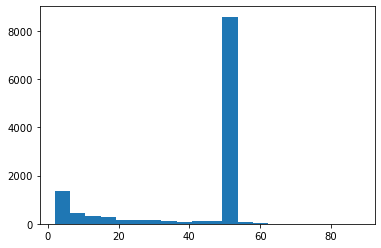

In [17]:
import matplotlib.pyplot as plt
plt.hist(n_confs, bins=20)

In [12]:
generated_CEL = ConformationEnsembleLibrary(generated_mols)

100%|███████████████████████████████████| 12024/12024 [00:01<00:00, 8465.33it/s]


In [13]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library_ccdc_generated.p'), 'wb') as f :
    pickle.dump(generated_CEL, f)
    
# here we only have the molecules parsed identically by RDKit (from mol2) and CSD (from smiles)

In [ ]:
# Because the SetProp was added later

In [4]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library_ccdc_generated.p'), 'rb') as f :
    generated_CEL = pickle.load(f)

In [6]:
generated_CEL.get_num_molecules()

12024

In [23]:
for smiles, ce in generated_CEL.get_unique_molecules() :
    original_mol = all_CEL.get_conf_ensemble(smiles).mol
    generated_conf_ids = range(original_mol.GetNumConformers(), ce.mol.GetNumConformers())
    for conf_id in generated_conf_ids :
        conf = ce.mol.GetConformer(conf_id)
        conf.SetProp('Generator', 'CCDC')

In [28]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library_ccdc_generated.p'), 'wb') as f :
    pickle.dump(generated_CEL, f)

In [26]:
for smiles, ce in generated_CEL.get_unique_molecules() :
    print ([conf.HasProp('Generator') for conf in ce.mol.GetConformers()])

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
from mol_viewer import MolViewer
MolViewer().view(generated_mols[4565])

NameError: name 'generated_mols' is not defined